# Load helper packages

In [1]:
import sys
sys.path.append("./")

import time
import os
import sys
import random
import numpy as np
import pandas as pd 
import h5py
import json
import pickle
import anndata
import scanpy as sc
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import glob
import scprep as scp
import anndata as ad
import seaborn as sns
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from window_adata import *

from tqdm import tqdm
from scipy.stats import pearsonr,spearmanr
from scipy import stats
from torch.utils.data import DataLoader
from copy import deepcopy as dcp
from collections import defaultdict as dfd
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from pathlib import Path, PurePath
from typing import Union, Dict, Optional, Tuple, BinaryIO
from matplotlib.image import imread
from scanpy import read_visium, read_10x_mtx
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None
from anndata import read as read_h5ad
from pathlib import Path, PurePath
from typing import Union, Dict, Optional, Tuple, BinaryIO
from matplotlib.image import imread
from anndata import (
    AnnData,
    read_csv,
    read_text,
    read_excel,
    read_mtx,
    read_loom,
    read_hdf,)


# Load visium dataset
* Training dataset: 6 samples from Alex_NatGen
* Testing dataset: 3 samples from 10x visium
* Using sliding window to split the WSI image into many tiles, the window size is 4000px without overlapping.

In [2]:
# set random seed
def setup_seed(seed=12000):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    

In [3]:
""" Integrate two visium datasets """
data_dir1 = "./Alex_NatGen_6BreastCancer/"
data_dir2 = "./breast_cancer_10x_visium/"

samps1 = ["1142243F", "CID4290", "CID4465", "CID44971", "CID4535", "1160920F"]
samps2 = ["block1", "block2", "FFPE"]

sampsall = samps1 + samps2
samples1 = {i:data_dir1 + i for i in samps1}
samples2 = {i:data_dir2 + i for i in samps2}

# Specify the train and test sample name
train_sample = samps1
test_sample = samps2

# Marker gene list
gene_list = ["COX6C","TTLL12", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]

# # Load windowed dataset
import pickle
with open('/scratch/imb/uqyjia11/Yuanhao/10X_visium/CNN_GAT/10x_visium_dataset_without_window.pickle', 'rb') as f:
    adata_dict0 = pickle.load(f)
    
# Define the gridding size
sizes = [4000 for i in range(len(adata_dict0))]

# Split tiles into smaller patches according to gridding size
adata_dict = window_adata(adata_dict0, sizes)

# Specify the windowed samples name
tr_name = list(set([i for i in list(adata_dict.keys()) for tr in train_sample if tr in i]))
te_name = list(set([i for i in list(adata_dict.keys()) for te in test_sample if te in i]))


Windowing 1142243F
Num spots:  4784
246
216
222
185
77
247
246
255
247
93
246
247
255
245
94
247
246
255
238
88
130
135
132
140
55
Total:  4787
Windowing CID4290
Num spots:  2714
793
576
1001
344
Total:  2714
Windowing CID4465
Num spots:  1310
345
258
149
558
Total:  1310
Windowing CID44971
Num spots:  1322
491
462
339
30
Total:  1322
Windowing CID4535
Num spots:  1431
564
232
632
3
Total:  1431
Windowing 1160920F
Num spots:  4895
210
251
251
239
83
226
255
232
240
102
231
230
246
247
99
238
246
247
255
93
144
147
164
160
60
Total:  4896
Windowing block1
Num spots:  3798
139
205
219
185
10
169
246
247
255
16
189
230
205
233
0
197
156
241
228
0
72
106
129
124
0
Total:  3801
Windowing block2
Num spots:  3987
224
247
246
229
208
246
247
231
243
207
211
196
221
195
254
205
81
97
108
92
Total:  3988
Windowing FFPE
Num spots:  2518
50
190
188
79
0
169
219
216
189
0
182
215
201
192
0
68
138
159
63
0
0
1
0
0
0
Total:  2519
Windowing 1168993F
Num spots:  4898
244
249
248
244
68
246
247
255
246


In [4]:
from data_vit import ViT_Anndata

def dataset_wrap(dataloader= True):
    train_sample = ["1142243F", "CID4465", "CID44971", "CID4535"]

    tr_name = list(set([i for i in list(adata_dict.keys()) for tr in train_sample if tr in i]))

    trainset = ViT_Anndata(adata_dict = adata_dict, train_set = tr_name, gene_list = gene_list, processed_img=None, train=True, flatten=False, ori=True, prune='NA', neighs=4, )
    print("Loaded Trainset")
    
    train_loader = DataLoader(trainset, batch_size=1, num_workers=0, shuffle=True)
    if dataloader==True:
        return train_loader
    else:
        return trainset

In [5]:
"""Load dataset"""
val_sample = ["CID4290", "1160920F"]
train_loader = dataset_wrap(dataloader= True)


Eval set:  ['1142243F_0', '1142243F_10', '1142243F_5', '1142243F_19', '1142243F_3', '1142243F_9', '1142243F_13', '1142243F_24', 'CID4535_1', '1142243F_2', 'CID44971_1', '1142243F_21', 'CID44971_2', '1142243F_18', '1142243F_22', '1142243F_11', 'CID44971_0', 'CID4465_1', 'CID4535_0', '1142243F_15', '1142243F_12', '1142243F_1', 'CID4465_0', '1142243F_14', '1142243F_8', 'CID4465_3', '1142243F_20', '1142243F_17', 'CID4465_2', '1142243F_7', '1142243F_16', 'CID4535_2', '1142243F_23', '1142243F_4', 'CID44971_3', '1142243F_6']
Loading imgs...
Loaded Trainset


## Save image into PKL files

In [6]:
import pickle
tr_imgs = {}
i = 0 
tr_name = ['CID4465_0', '1142243F_12', '1142243F_14', 'CID4465_3', 'CID44971_2', 'CID4535_2', '1142243F_21', '1142243F_0', '1142243F_3', '1142243F_10', '1142243F_23', '1142243F_22', 'CID44971_0', 'CID4465_2', '1142243F_9', '1142243F_2', '1142243F_18', 'CID4465_1', 'CID44971_1', '1142243F_19', 'CID4535_0', '1142243F_13', '1142243F_16', '1142243F_15', '1142243F_5', 'CID4535_1', '1142243F_11', '1142243F_6', '1142243F_8', 'CID44971_3', '1142243F_20', '1142243F_24', '1142243F_4', '1142243F_17', '1142243F_1', '1142243F_7']

for patch, *_ in train_loader:
    tr_imgs[tr_name[i]] = patch.squeeze().permute(0,2,3,1).numpy().astype(np.uint8)
    i = i+1
print(tr_imgs.keys())
    
with open('Train_samples.pkl', 'wb') as f:
    # A new file will be created
    pickle.dump(tr_imgs, f)
print("Done!")

dict_keys(['CID4465_0', '1142243F_12', '1142243F_14', 'CID4465_3', 'CID44971_2', 'CID4535_2', '1142243F_21', '1142243F_0', '1142243F_3', '1142243F_10', '1142243F_23', '1142243F_22', 'CID44971_0', 'CID4465_2', '1142243F_9', '1142243F_2', '1142243F_18', 'CID4465_1', 'CID44971_1', '1142243F_19', 'CID4535_0', '1142243F_13', '1142243F_16', '1142243F_15', '1142243F_5', 'CID4535_1', '1142243F_11', '1142243F_6', '1142243F_8', 'CID44971_3', '1142243F_20', '1142243F_24', '1142243F_4', '1142243F_17', '1142243F_1', '1142243F_7'])
Done!


## Visualization of Raw  Tiles

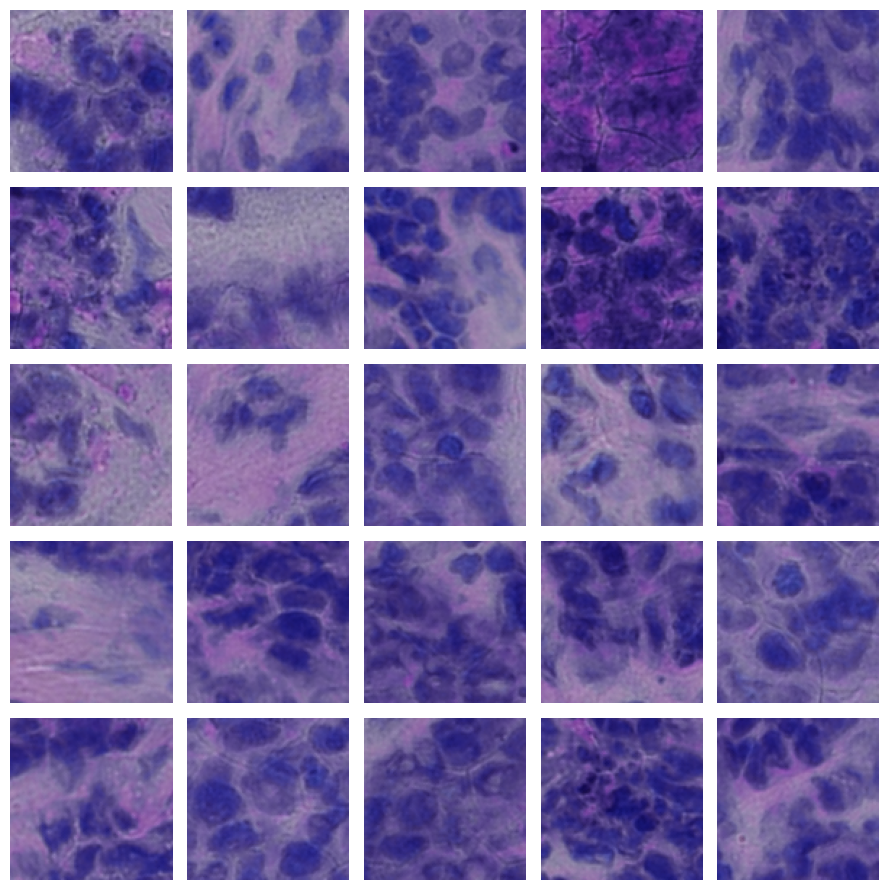

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the raw tiles from the pickle file
with open(f'Train_samples.pkl', 'rb') as f:
    raw_img = pickle.load(f)

tr_name = ['CID4465_0', '1142243F_12', '1142243F_14', 'CID4465_3', 'CID44971_2', 'CID4535_2', '1142243F_21', '1142243F_0', '1142243F_3', '1142243F_10', '1142243F_23', '1142243F_22', 'CID44971_0', 'CID4465_2', '1142243F_9', '1142243F_2', '1142243F_18', 'CID4465_1', 'CID44971_1', '1142243F_19', 'CID4535_0', '1142243F_13', '1142243F_16', '1142243F_15', '1142243F_5', 'CID4535_1', '1142243F_11', '1142243F_6', '1142243F_8', 'CID44971_3', '1142243F_20', '1142243F_24', '1142243F_4', '1142243F_17', '1142243F_1', '1142243F_7']

# Create a sample numpy array (replace this with your actual data)
image_array = raw_img[tr_name[0]][:25]

# Calculate the number of rows and columns for subplots
num_images = image_array.shape[0]
num_rows = int(np.sqrt(num_images))
num_cols = int(np.ceil(num_images / num_rows))

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 9))

# Flatten the axes array to handle different subplot grid shapes
axes = axes.flatten()

# Iterate through the images and display them
for i in range(num_images):
    if i < num_images:
        axes[i].imshow(image_array[i])
        axes[i].axis('off')  # Turn off axis labels

# Remove any remaining empty subplots
for i in range(num_images, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [15]:
import gc
gc.collect()

20

# Augmentaion methods

In [14]:
import cv2
import numpy as np
from skimage import color
from typing import Optional, Dict
import yaml

class Dict2Class(object):
    # ToDo: Wrap into RandStainNA
    def __init__(self, my_dict: Dict):
        self.my_dict = my_dict
        for key in my_dict:
            setattr(self, key, my_dict[key])


def get_yaml_data(yaml_file):
    # ToDo: Wrap into RandStainNA
    file = open(yaml_file, "r", encoding="utf-8")
    file_data = file.read()
    file.close()
    # str->dict
    data = yaml.load(file_data, Loader=yaml.FullLoader)

    return data


class RandStainNA(object):
    def __init__(
        self,
        yaml_file: str,
        std_hyper: Optional[float] = 0,
        distribution: Optional[str] = "normal",
        probability: Optional[float] = 1.0,
        is_train: Optional[bool] = True,
    ):

        # true:training setting/false: demo setting

        assert distribution in [
            "normal",
            "laplace",
            "uniform",
        ], "Unsupported distribution style {}.".format(distribution)

        self.yaml_file = yaml_file
        cfg = get_yaml_data(self.yaml_file)
        c_s = cfg["color_space"]

        self._channel_avgs = {
            "avg": [
                cfg[c_s[0]]["avg"]["mean"],
                cfg[c_s[1]]["avg"]["mean"],
                cfg[c_s[2]]["avg"]["mean"],
            ],
            "std": [
                cfg[c_s[0]]["avg"]["std"],
                cfg[c_s[1]]["avg"]["std"],
                cfg[c_s[2]]["avg"]["std"],
            ],
        }
        self._channel_stds = {
            "avg": [
                cfg[c_s[0]]["std"]["mean"],
                cfg[c_s[1]]["std"]["mean"],
                cfg[c_s[2]]["std"]["mean"],
            ],
            "std": [
                cfg[c_s[0]]["std"]["std"],
                cfg[c_s[1]]["std"]["std"],
                cfg[c_s[2]]["std"]["std"],
            ],
        }

        self.channel_avgs = Dict2Class(self._channel_avgs)
        self.channel_stds = Dict2Class(self._channel_stds)

        self.color_space = cfg["color_space"]
        self.p = probability
        self.std_adjust = std_hyper
        self.color_space = c_s
        self.distribution = distribution
        self.is_train = is_train

    def _getavgstd(self, image: np.ndarray, isReturnNumpy: Optional[bool] = True):

        avgs = []
        stds = []

        num_of_channel = image.shape[2]
        for idx in range(num_of_channel):
            avgs.append(np.mean(image[:, :, idx]))
            stds.append(np.std(image[:, :, idx]))

        if isReturnNumpy:
            return (np.array(avgs), np.array(stds))
        else:
            return (avgs, stds)

    def _normalize(
        self,
        img: np.ndarray,
        img_avgs: np.ndarray,
        img_stds: np.ndarray,
        tar_avgs: np.ndarray,
        tar_stds: np.ndarray,
    ) -> np.ndarray:

        img_stds = np.clip(img_stds, 0.0001, 255)
        img = (img - img_avgs) * (tar_stds / img_stds) + tar_avgs

        if self.color_space in ["LAB", "HSV"]:
            img = np.clip(img, 0, 255).astype(np.uint8)

        return img

    def augment(self, img):
        # img:is_train:false——>np.array()(cv2.imread()) #BGR
        # img:is_train:True——>PIL.Image #RGB

        if self.is_train == False:
            image = img
        else:
            image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

        num_of_channel = image.shape[2]

        # color space transfer
        if self.color_space == "LAB":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        elif self.color_space == "HSV":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.color_space == "HED":
            image = color.rgb2hed(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        std_adjust = self.std_adjust

        # virtual template generation
        tar_avgs = []
        tar_stds = []
        if self.distribution == "uniform":

            # three-sigma rule for uniform distribution
            for idx in range(num_of_channel):

                tar_avg = np.random.uniform(
                    low=self.channel_avgs.avg[idx] - 3 * self.channel_avgs.std[idx],
                    high=self.channel_avgs.avg[idx] + 3 * self.channel_avgs.std[idx],
                )
                tar_std = np.random.uniform(
                    low=self.channel_stds.avg[idx] - 3 * self.channel_stds.std[idx],
                    high=self.channel_stds.avg[idx] + 3 * self.channel_stds.std[idx],
                )

                tar_avgs.append(tar_avg)
                tar_stds.append(tar_std)
        else:
            if self.distribution == "normal":
                np_distribution = np.random.normal
            elif self.distribution == "laplace":
                np_distribution = np.random.laplace

            for idx in range(num_of_channel):
                tar_avg = np_distribution(
                    loc=self.channel_avgs.avg[idx],
                    scale=self.channel_avgs.std[idx] * (1 + std_adjust),
                )

                tar_std = np_distribution(
                    loc=self.channel_stds.avg[idx],
                    scale=self.channel_stds.std[idx] * (1 + std_adjust),
                )
                tar_avgs.append(tar_avg)
                tar_stds.append(tar_std)

        tar_avgs = np.array(tar_avgs)
        tar_stds = np.array(tar_stds)

        img_avgs, img_stds = self._getavgstd(image)

        image = self._normalize(
            img=image,
            img_avgs=img_avgs,
            img_stds=img_stds,
            tar_avgs=tar_avgs,
            tar_stds=tar_stds,
        )

        if self.color_space == "LAB":
            image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
        elif self.color_space == "HSV":
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        elif self.color_space == "HED":
            nimg = color.hed2rgb(image)
            imin = nimg.min()
            imax = nimg.max()
            rsimg = (255 * (nimg - imin) / (imax - imin)).astype(
                "uint8"
            )  # rescale to [0,255]

            image = cv2.cvtColor(rsimg, cv2.COLOR_RGB2BGR)

        return image

    def __call__(self, img):
        if np.random.rand(1) < self.p:
            return self.augment(img)
        else:
            return img

    def __repr__(self):
        format_string = self.__class__.__name__ + "("
        format_string += f"methods=Reinhard"
        format_string += f", colorspace={self.color_space}"
        format_string += f", mean={self._channel_avgs}"
        format_string += f", std={self._channel_stds}"
        format_string += f", std_adjust={self.std_adjust}"
        format_string += f", distribution={self.distribution}"
        format_string += f", p={self.p})"
        return format_string


In [15]:
import stainlib as stainlib
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from stainlib.utils.plot_utils import _plot_imagegrid
from stainlib.augmentation.augmenter import StainAugmentor
from stainlib.augmentation.augmenter import GrayscaleAugmentor
from stainlib.augmentation.augmenter import HedLighterColorAugmenter

methods = ["Grayscale", "HE-Intensity", "RandStainNA", "Macenko", "Vahadane", "None"]
def color_aug(patch=None, method="HE-Intensity"):
    start_time = time.time()
    aug_patch = None
    trans_patch = []
    for i in range(patch.shape[0]):
        patch1 = patch[i]
        if method == "Grayscale":
            grayscale_aug = GrayscaleAugmentor()
            grayscale_aug.fit(patch1)
            aug_patch = grayscale_aug.pop()
        elif method == "HE-Intensity":
            hed_lighter_aug = HedLighterColorAugmenter()
            hed_lighter_aug.randomize()
            aug_patch = hed_lighter_aug.transform(patch1)
        elif method =="RandStainNA":
            from torchvision import transforms
            transforms_list = [
                RandStainNA(
                    yaml_file="/scratch/imb/uqyjia11/Yuanhao/10X_visium/Augmentation_comparison/LAB_visium.yaml",
                    std_hyper=-0.3,
                    probability=1.0,
                    distribution="normal",
                    is_train=True, )]
            
            tf = transforms.Compose(transforms_list)
            aug_patch = tf(patch1)
        elif method == "Macenko":
            #Extraction of the concentration matrices
            macenko_augmentor = StainAugmentor(method='macenko')
            macenko_augmentor.fit(patch1)
            aug_patch = macenko_augmentor.pop()
        elif method == "Vahadane":
            #Extraction of the concentration matrices
            vahadane_augmentor = StainAugmentor(method='vahadane')
            #Train a model to augment source image
            vahadane_augmentor.fit(patch1)
            aug_patch = vahadane_augmentor.pop()
        elif method == "None":
            aug_patch = patch1
        trans_patch.append(aug_patch)
    aug_patch = np.array(trans_patch)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Color augmentation cost {execution_time} seconds({method})")
    return aug_patch
        

In [ ]:
import pickle

# Specify the path to the trainset pickle file
file_path = './Processed_tiles/Train_samples.pkl'

# Load the raw tiles from the pickle file
with open(file_path, 'rb') as f:
    dict1 = pickle.load(f)
dict1

In [30]:
aug_img = {}
methods = ["Grayscale", "HE-Intensity", "RandStainNA"]
# methods = ["RandStainNA"]

for method in methods:
    for i in range(len(tr_name)):
        patch = color_aug(patch = dict1[tr_name[i]], method=method)
        aug_img[tr_name[i]] = patch
        
    import pickle
    with open(f'Train-aug-{method}-samples.pkl', 'wb') as f:
        # A new file will be created
        pickle.dump(aug_img, f)


Color augmentation cost 0.21465277671813965 seconds(Grayscale)
Color augmentation cost 0.11984419822692871 seconds(Grayscale)
Color augmentation cost 0.12410998344421387 seconds(Grayscale)
Color augmentation cost 0.04702901840209961 seconds(Grayscale)
Color augmentation cost 0.47246479988098145 seconds(Grayscale)
Color augmentation cost 0.21987462043762207 seconds(Grayscale)
Color augmentation cost 0.11153769493103027 seconds(Grayscale)
Color augmentation cost 0.06964778900146484 seconds(Grayscale)
Color augmentation cost 0.11257505416870117 seconds(Grayscale)
Color augmentation cost 0.16381311416625977 seconds(Grayscale)
Color augmentation cost 0.11129164695739746 seconds(Grayscale)
Color augmentation cost 0.11443758010864258 seconds(Grayscale)
Color augmentation cost 0.09794068336486816 seconds(Grayscale)
Color augmentation cost 0.11653900146484375 seconds(Grayscale)
Color augmentation cost 0.2667832374572754 seconds(Grayscale)
Color augmentation cost 0.11927199363708496 seconds(Gray

## Visualization of RandStainNA augmentation tiles

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Load the raw tiles from the pickle file
method = "RandStainNA"
with open(f'Train-aug-{method}-samples.pkl', 'rb') as f:
    aug_img = pickle.load(f)

# Create a sample numpy array (replace this with your actual data)
image_array = aug_img[tr_name[0]][:25]

# Calculate the number of rows and columns for subplots
num_images = image_array.shape[0]
num_rows = int(np.sqrt(num_images))
num_cols = int(np.ceil(num_images / num_rows))

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 9))

# Flatten the axes array to handle different subplot grid shapes
axes = axes.flatten()

# Iterate through the images and display them
for i in range(num_images):
    if i < num_images:
        axes[i].imshow(image_array[i])
        axes[i].axis('off')  # Turn off axis labels

# Remove any remaining empty subplots
for i in range(num_images, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Visualization of H&E-Intensity augmentation tiles

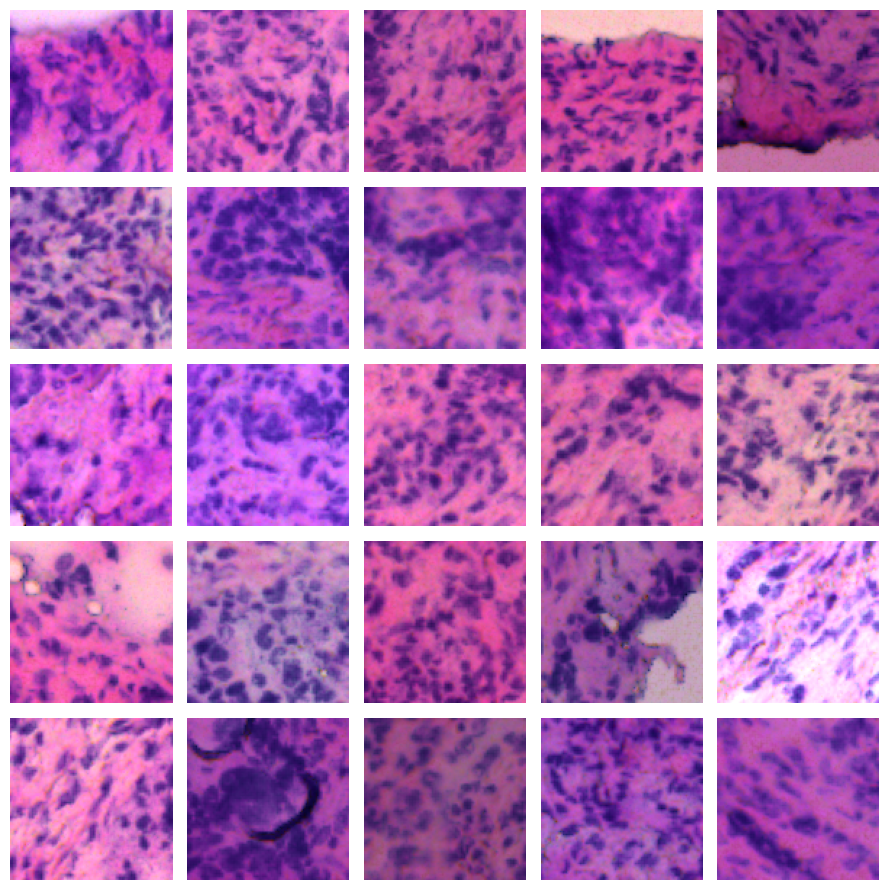

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Load the raw tiles from the pickle file
method = "HE-Intensity"
with open(f'Train-aug-{method}-samples.pkl', 'rb') as f:
    aug_img = pickle.load(f)

# Create a sample numpy array (replace this with your actual data)
image_array = aug_img[tr_name[0]][:25]

# Calculate the number of rows and columns for subplots
num_images = image_array.shape[0]
num_rows = int(np.sqrt(num_images))
num_cols = int(np.ceil(num_images / num_rows))

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 9))

# Flatten the axes array to handle different subplot grid shapes
axes = axes.flatten()

# Iterate through the images and display them
for i in range(num_images):
    if i < num_images:
        axes[i].imshow(image_array[i])
        axes[i].axis('off')  # Turn off axis labels

# Remove any remaining empty subplots
for i in range(num_images, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Visualization of Grayscale augmentation tiles

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Load the raw tiles from the pickle file
method = "Grayscale"
with open(f'Train-aug-{method}-samples.pkl', 'rb') as f:
    aug_img = pickle.load(f)

# Create a sample numpy array (replace this with your actual data)
image_array = aug_img[tr_name[0]][:25]

# Calculate the number of rows and columns for subplots
num_images = image_array.shape[0]
num_rows = int(np.sqrt(num_images))
num_cols = int(np.ceil(num_images / num_rows))

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axes array to handle different subplot grid shapes
axes = axes.flatten()

# Iterate through the images and display them
for i in range(num_images):
    if i < num_images:
        axes[i].imshow(image_array[i])
        axes[i].axis('off')  # Turn off axis labels

# Remove any remaining empty subplots
for i in range(num_images, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


# Color normalization

In [1]:
import stainlib
import requests
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
import time
from PIL import ImageFile, Image
from skimage.transform import resize
from io import BytesIO
from stainlib.utils.plot_utils import _plot_imagegrid
from stainlib.normalization.normalizer import ExtractiveStainNormalizer, ReinhardStainNormalizer
from stainlib.utils.stain_utils import is_uint8_image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = None


In [2]:
target = np.array(Image.open('/scratch/imb/uqyjia11/Yuanhao/10X_visium/breast_cancer_10x_visium/block1/image.tif'))

#  resize image
dim = (224, 224)
target = cv2.resize(target, dim, interpolation = cv2.INTER_AREA)
print("Resized reference image", target.shape)

Resized reference image (224, 224, 3)


In [ ]:
# Reference image
reference_img = np.array(Image.open("/scratch/imb/uqyjia11/Yuanhao/10X_visium/breast_cancer_10x_visium/block1/image.tif"))
plt.figure(figsize=(4,4))
plt.imshow(reference_img)
plt.axis("off")
plt.show()

In [ ]:
# Helper function

def stain_normalization(source_images=None, target=None, method="Vahadane"):
    start_time = time.time()
    trans_patch = []
    for i in range(source_images.shape[0]):
        source_image = source_images[i]
        if method == "Reinhard":
            normalizer = ReinhardStainNormalizer()

            # Standardize brightness (This step is optional but can improve the tissue mask calculation)
            target = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(target)

            # Train a model to fit the reference image
            normalizer.fit(target)

            # Vahadane normalization for all source images
            to_transform = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(source_image)
            transformed = normalizer.transform(to_transform)
            patch = np.squeeze(transformed)

        elif method == "Macenko":
            normalizer = stainlib.normalization.normalizer.ExtractiveStainNormalizer(method='macenko')

            # Standardize brightness (This step is optional but can improve the tissue mask calculation)
            target = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(target)

            # Train a model to fit the reference image
            normalizer.fit(target)

            # Vahadane normalization for all source images
            to_transform = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(source_image)

            transformed = normalizer.transform(to_transform)
            patch = np.squeeze(transformed)

        elif method == "Vahadane":
            normalizer = stainlib.normalization.normalizer.ExtractiveStainNormalizer(method='vahadane')

            # Standardize brightness (This step is optional but can improve the tissue mask calculation)
            target = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(target)

            # Train a model to fit the reference image
            normalizer.fit(target)

            # Vahadane normalization for all source images
            to_transform = stainlib.utils.stain_utils.LuminosityStandardizer.standardize(source_image)
            transformed = normalizer.transform(to_transform)
            patch = np.squeeze(transformed)
        elif method == "None":
            patch = patch
        trans_patch.append(patch)
    norm_patch = np.array(trans_patch)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Color normalization cost {execution_time} seconds({method})")
    return norm_patch
        

In [47]:
norm_img = {}
methods = ["Reinhard"]

for method in methods:
    for i in range(len(tr_name)):
        patch = stain_normalization(source_images=tr_imgs[tr_name[i]], target=target, method=method)
        norm_img[tr_name[i]] = patch
        
#     import pickle
#     with open(f'Train-aug-{method}-samples.pkl', 'wb') as f:
#         # A new file will be created
#         pickle.dump(norm_img, f)


Color normalization cost 3.5585973262786865 seconds(Reinhard)
Color normalization cost 0.3426182270050049 seconds(Reinhard)
Color normalization cost 3.8459229469299316 seconds(Reinhard)
Color normalization cost 1.4984166622161865 seconds(Reinhard)
Color normalization cost 1.5015952587127686 seconds(Reinhard)
Color normalization cost 1.4995448589324951 seconds(Reinhard)
Color normalization cost 1.5487124919891357 seconds(Reinhard)
Color normalization cost 2.050600528717041 seconds(Reinhard)
Color normalization cost 1.5515398979187012 seconds(Reinhard)
Color normalization cost 1.508784532546997 seconds(Reinhard)
Color normalization cost 1.346067190170288 seconds(Reinhard)
Color normalization cost 1.5770764350891113 seconds(Reinhard)
Color normalization cost 3.0026261806488037 seconds(Reinhard)
Color normalization cost 3.3812286853790283 seconds(Reinhard)
Color normalization cost 1.2780814170837402 seconds(Reinhard)
Color normalization cost 1.458268642425537 seconds(Reinhard)
Color normal

In [16]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the raw tiles from the pickle file
with open(f'Train_samples.pkl', 'rb') as f:
    raw_img = pickle.load(f)

tr_name = ['CID4465_0', '1142243F_12', '1142243F_14', 'CID4465_3', 'CID44971_2', 'CID4535_2', '1142243F_21', '1142243F_0', '1142243F_3', '1142243F_10', '1142243F_23', '1142243F_22', 'CID44971_0', 'CID4465_2', '1142243F_9', '1142243F_2', '1142243F_18', 'CID4465_1', 'CID44971_1', '1142243F_19', 'CID4535_0', '1142243F_13', '1142243F_16', '1142243F_15', '1142243F_5', 'CID4535_1', '1142243F_11', '1142243F_6', '1142243F_8', 'CID44971_3', '1142243F_20', '1142243F_24', '1142243F_4', '1142243F_17', '1142243F_1', '1142243F_7']

# Create a sample numpy array (replace this with your actual data)
image_array = raw_img[tr_name[5]][:25]

# Calculate the number of rows and columns for subplots
num_images = image_array.shape[0]
num_rows = int(np.sqrt(num_images))
num_cols = int(np.ceil(num_images / num_rows))

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(9, 9))

# Flatten the axes array to handle different subplot grid shapes
axes = axes.flatten()

# Iterate through the images and display them
for i in range(num_images):
    if i < num_images:
        axes[i].imshow(image_array[i])
        axes[i].axis('off')  # Turn off axis labels

# Remove any remaining empty subplots
for i in range(num_images, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## Visualization of Reinhard Normalization Tiles

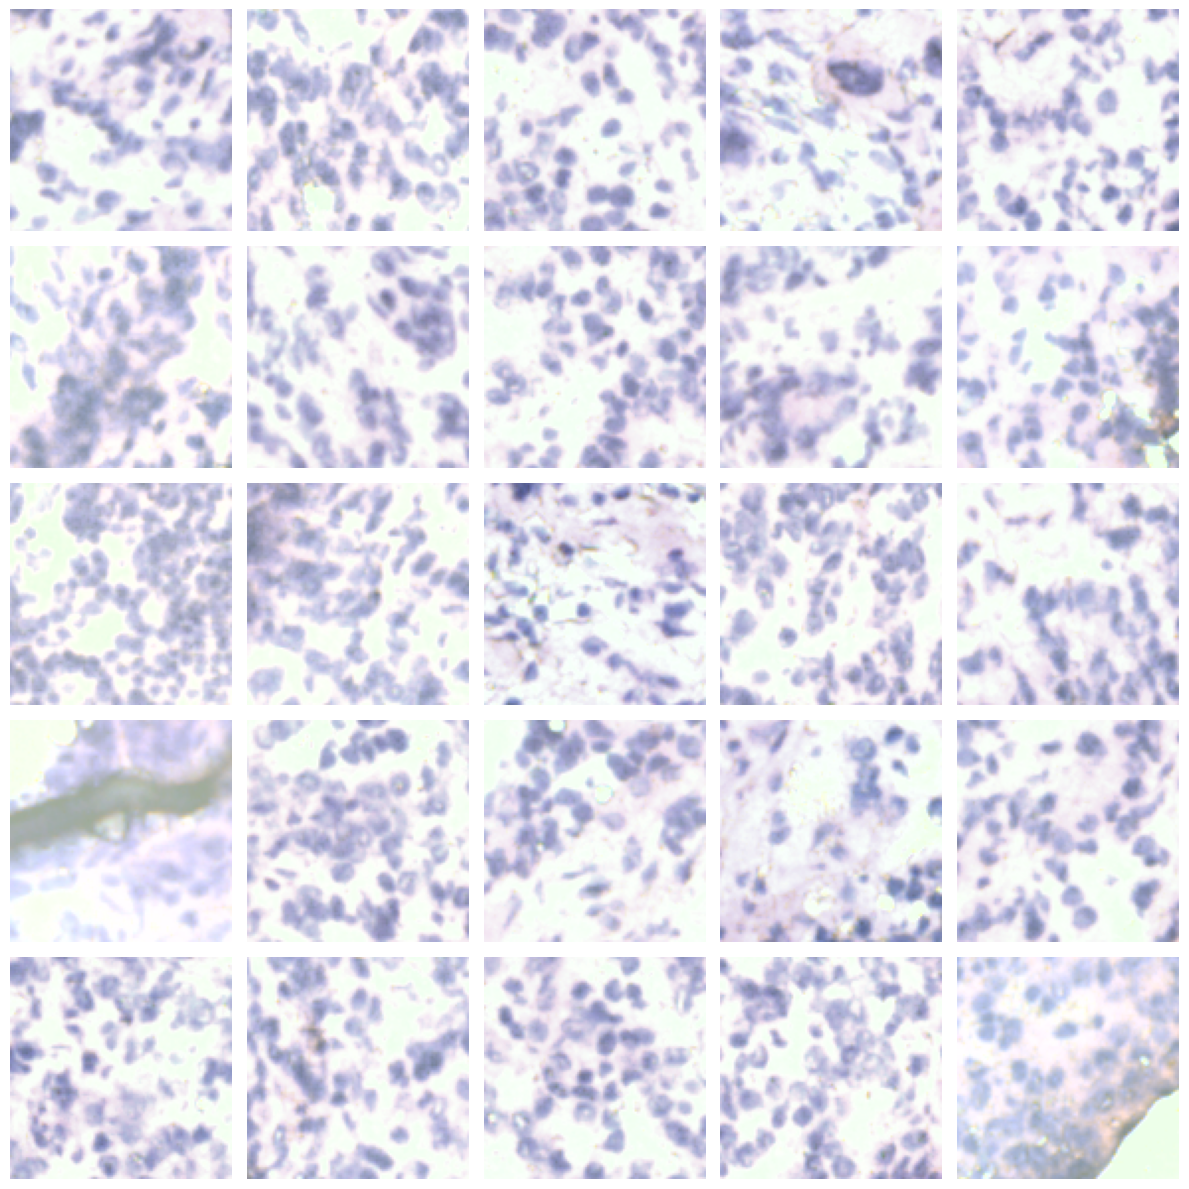

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sample numpy array (replace this with your actual data)
image_array = norm_img[tr_name[0]][:25]

# Calculate the number of rows and columns for subplots
num_images = image_array.shape[0]
num_rows = int(np.sqrt(num_images))
num_cols = int(np.ceil(num_images / num_rows))

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axes array to handle different subplot grid shapes
axes = axes.flatten()

# Iterate through the images and display them
for i in range(num_images):
    if i < num_images:
        axes[i].imshow(image_array[i])
        axes[i].axis('off')  # Turn off axis labels

# Remove any remaining empty subplots
for i in range(num_images, num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()
